In [1]:
import os
import numpy as np
import scanpy as sc
import pandas as pd
import torch
import torch.nn as nn
from scVAE import scVAE
import matplotlib.pyplot as plt
torch.manual_seed(0)
sc.settings.set_figure_params(dpi=100, figsize=(5,5), frameon=False)

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Load and prepare the data

In [2]:
tm_droplet_path = os.path.join('./data', "TM_droplet.h5ad")
tm_droplet = sc.read(
    tm_droplet_path,
    backup_url="https://figshare.com/ndownloader/files/23938934",
)

In [3]:
adata = tm_droplet[
    (tm_droplet.obs.tissue == "Marrow")
    & (~tm_droplet.obs.cell_ontology_class.isna())
    & (tm_droplet.obs.sex == "female")
].copy()

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [5]:
adata.layers['counts'] = adata.X.copy()

In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()
adata.raw = adata

In [7]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3', subset=True)

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [8]:
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=50, metric='cosine')
sc.tl.umap(adata, min_dist=0.3)

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


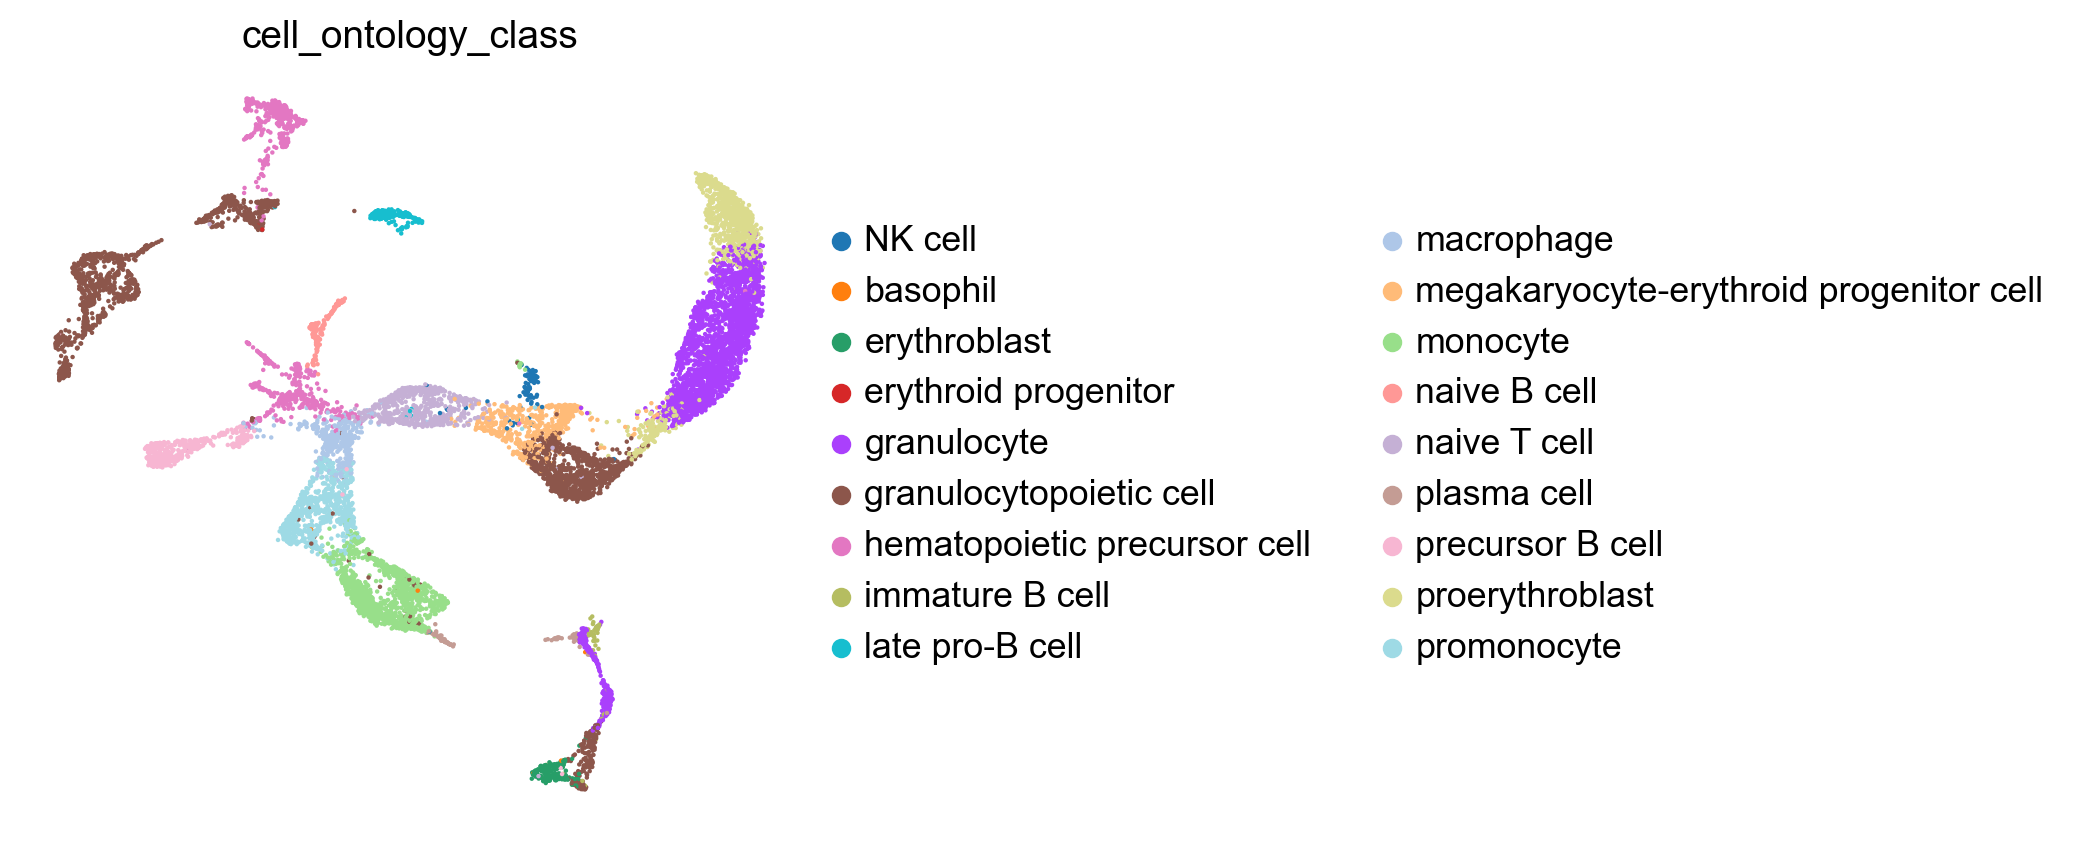

In [9]:
sc.pl.umap(adata, color=['cell_ontology_class'])

In [10]:
adata.obsm['X_umap_pca'] = adata.obsm['X_umap'].copy()

# Train VAE model

In [11]:
vae = scVAE.scVAE(adata, num_layers=2, hidden_size=64, latent_size=50, dropout_rate=0.1)

In [31]:
vae.prepare_adata(device='mps', layer='counts', batch_size=32)

In [13]:
# vae.fit(num_epochs=30, device='mps', loss_function=nn.PoissonNLLLoss(log_input=False))
vae.fit(num_epochs=100, device='mps')

Epoch [1/100], Loss: 1015.4385
Epoch [2/100], Loss: 601.2115
Epoch [3/100], Loss: 759.9969
Epoch [4/100], Loss: 359.9220
Epoch [5/100], Loss: 870.9290
Epoch [6/100], Loss: 547.7861
Epoch [7/100], Loss: 478.2185
Epoch [8/100], Loss: 549.1552
Epoch [9/100], Loss: 914.8386
Epoch [10/100], Loss: 221.9443
Epoch [11/100], Loss: 603.5085
Epoch [12/100], Loss: 145.7274
Epoch [13/100], Loss: 527.7672
Epoch [14/100], Loss: 609.1042
Epoch [15/100], Loss: 351.0553
Epoch [16/100], Loss: 225.4444
Epoch [17/100], Loss: 950.2505
Epoch [18/100], Loss: 591.5829
Epoch [19/100], Loss: 458.0269
Epoch [20/100], Loss: 162.8505
Epoch [21/100], Loss: 265.2809
Epoch [22/100], Loss: 718.5861
Epoch [23/100], Loss: 245.8999
Epoch [24/100], Loss: 135.3308
Epoch [25/100], Loss: 162.3104
Epoch [26/100], Loss: 617.9389
Epoch [27/100], Loss: 156.8330
Epoch [28/100], Loss: 214.9379
Epoch [29/100], Loss: 242.8989
Epoch [30/100], Loss: 135.7423
Epoch [31/100], Loss: 207.0131
Epoch [32/100], Loss: 182.2971
Epoch [33/100], 

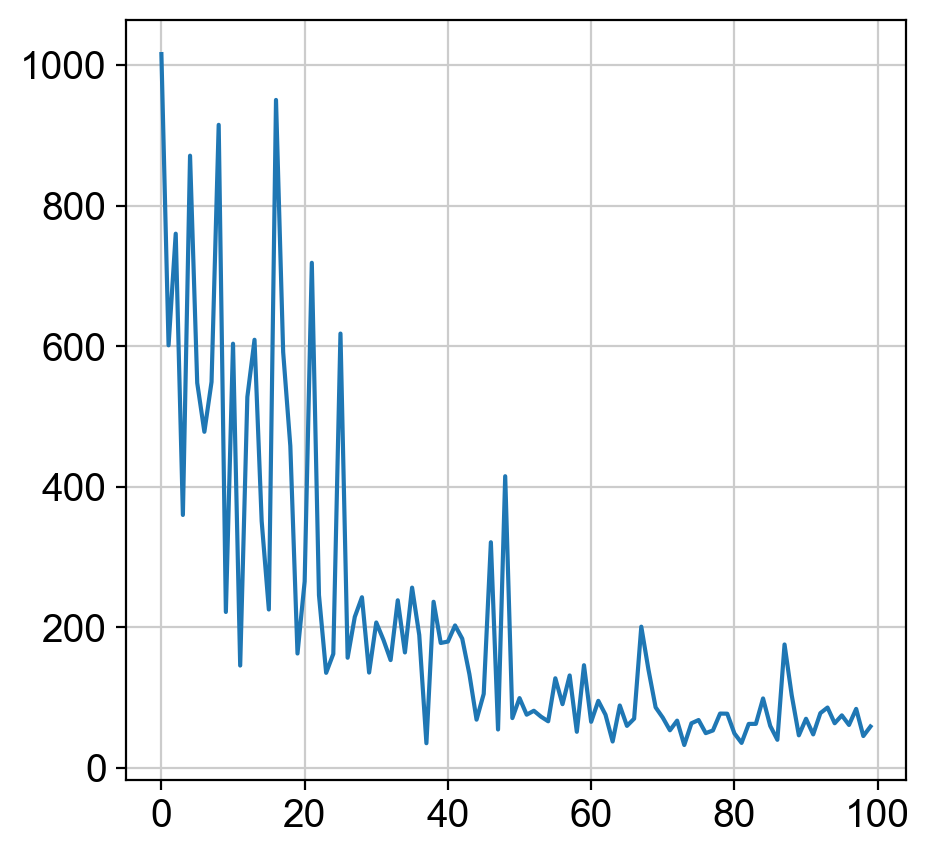

In [14]:
plt.plot(vae.history['loss'])

In [15]:
vae.to('cpu')
adata.obsm['X_vae'] = vae.get_latent(device='cpu')
adata.layers['vae'] = vae.reconstruc_counts(device='cpu')

/Users/pax/scVAE/scVAE/scVAE.py:154: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454852765/work/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
  X = torch.tensor(self.adata.X).to_sparse_csr().to(device)


In [16]:
sc.pp.neighbors(adata, use_rep='X_vae', n_neighbors=50, metric='cosine')
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, resolution=0.5)

In [17]:
adata.X = adata.layers['vae'].copy()
# sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers['log_vae'] = adata.X.copy()

In [32]:
vae.save('vae_model')

Model saved to vae_model/model.pk


In [19]:
adata.write('./data/TM_droplet_vae.h5ad')

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


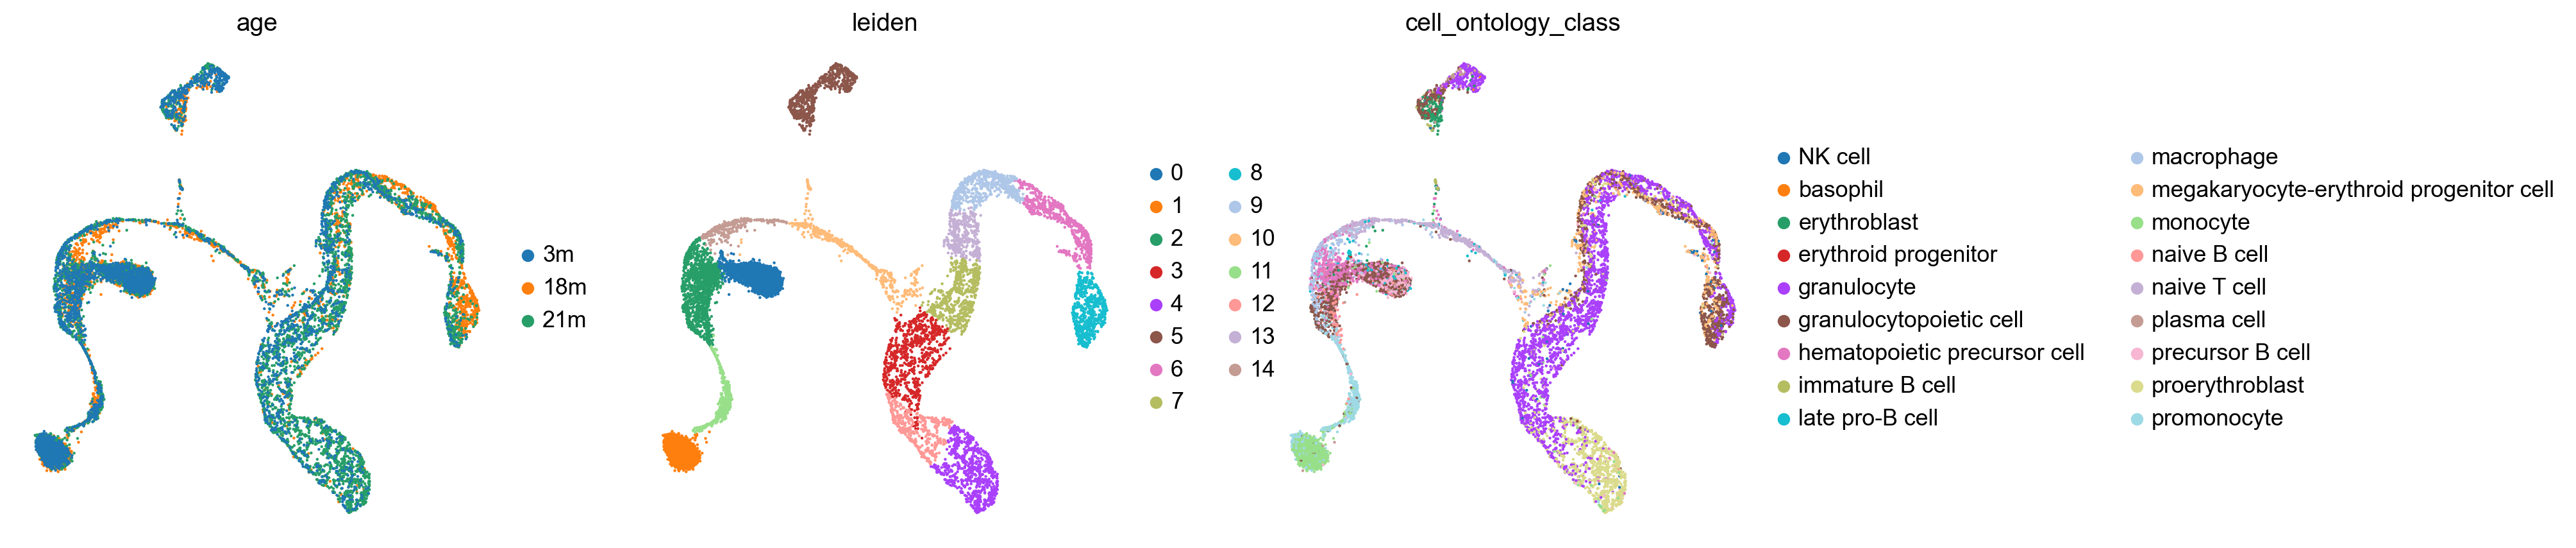

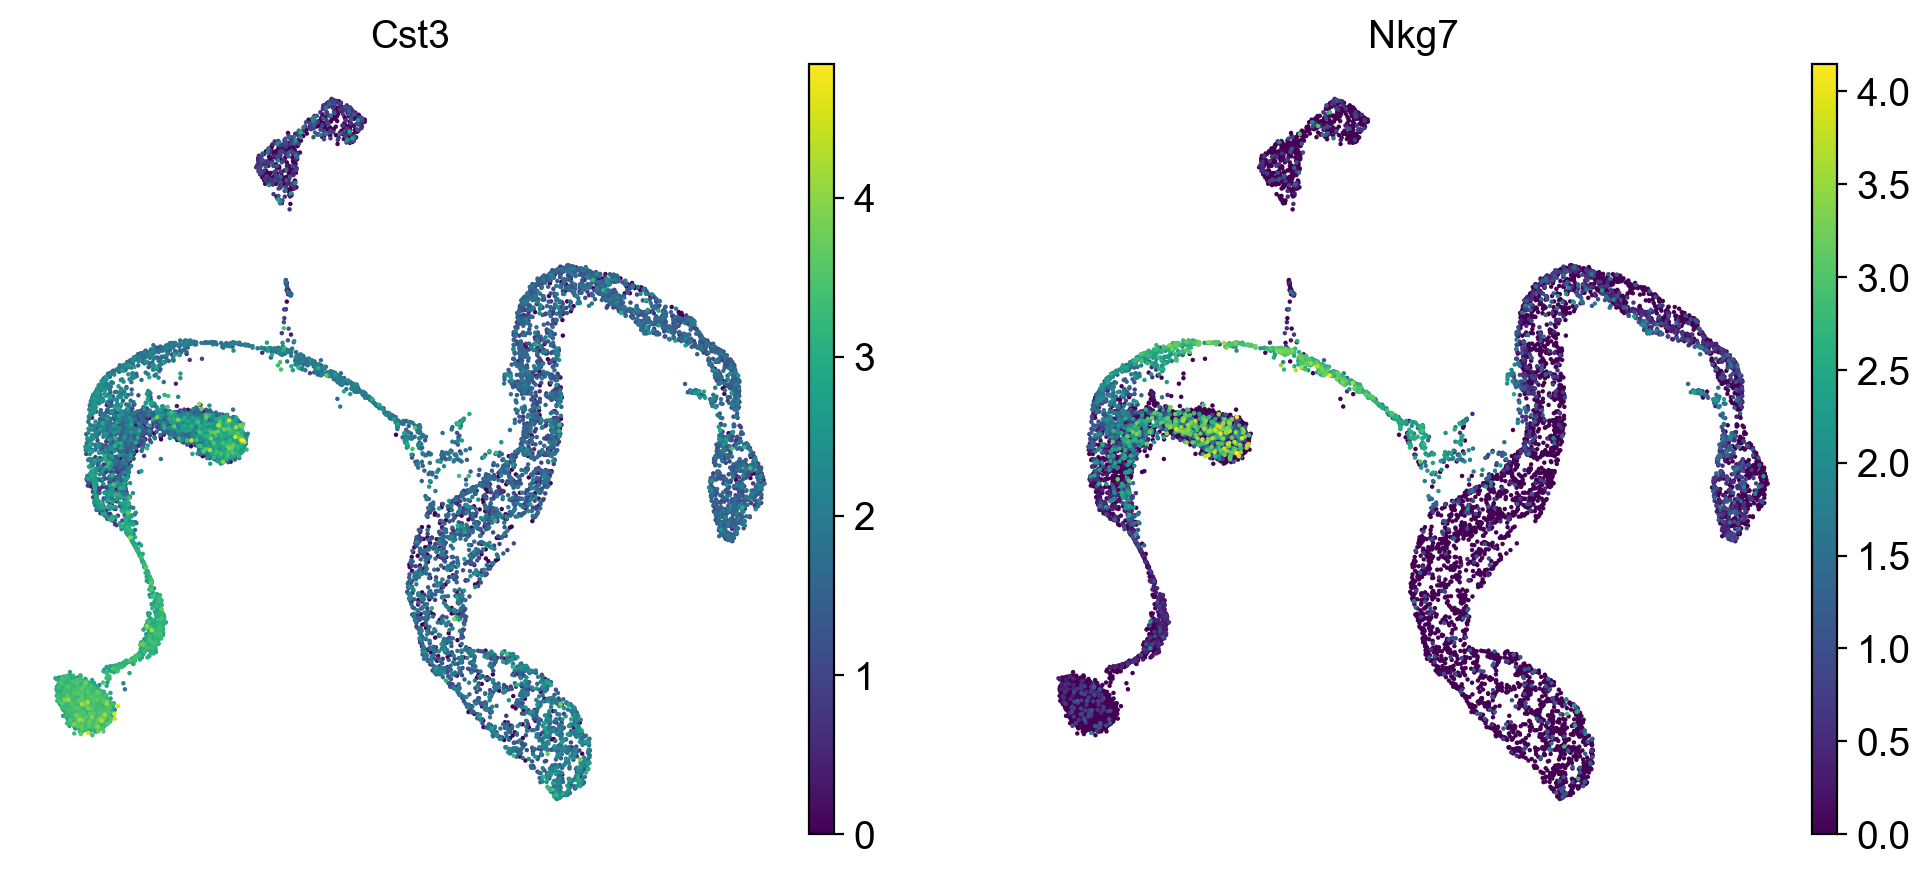

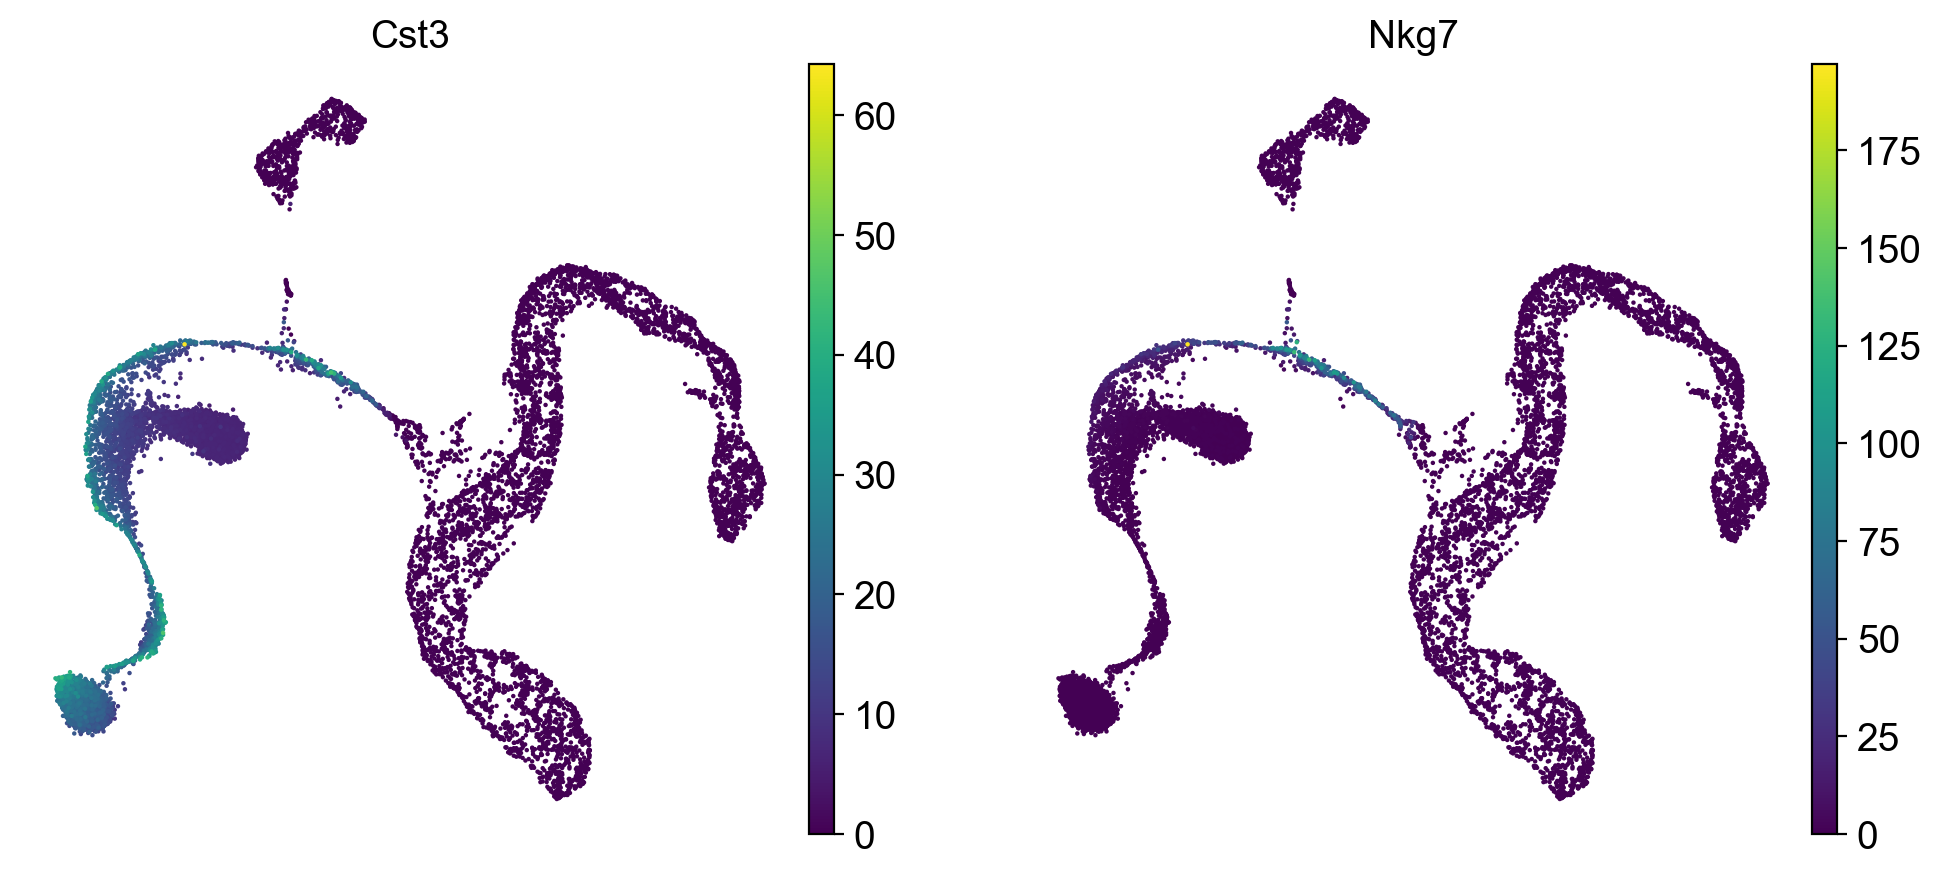

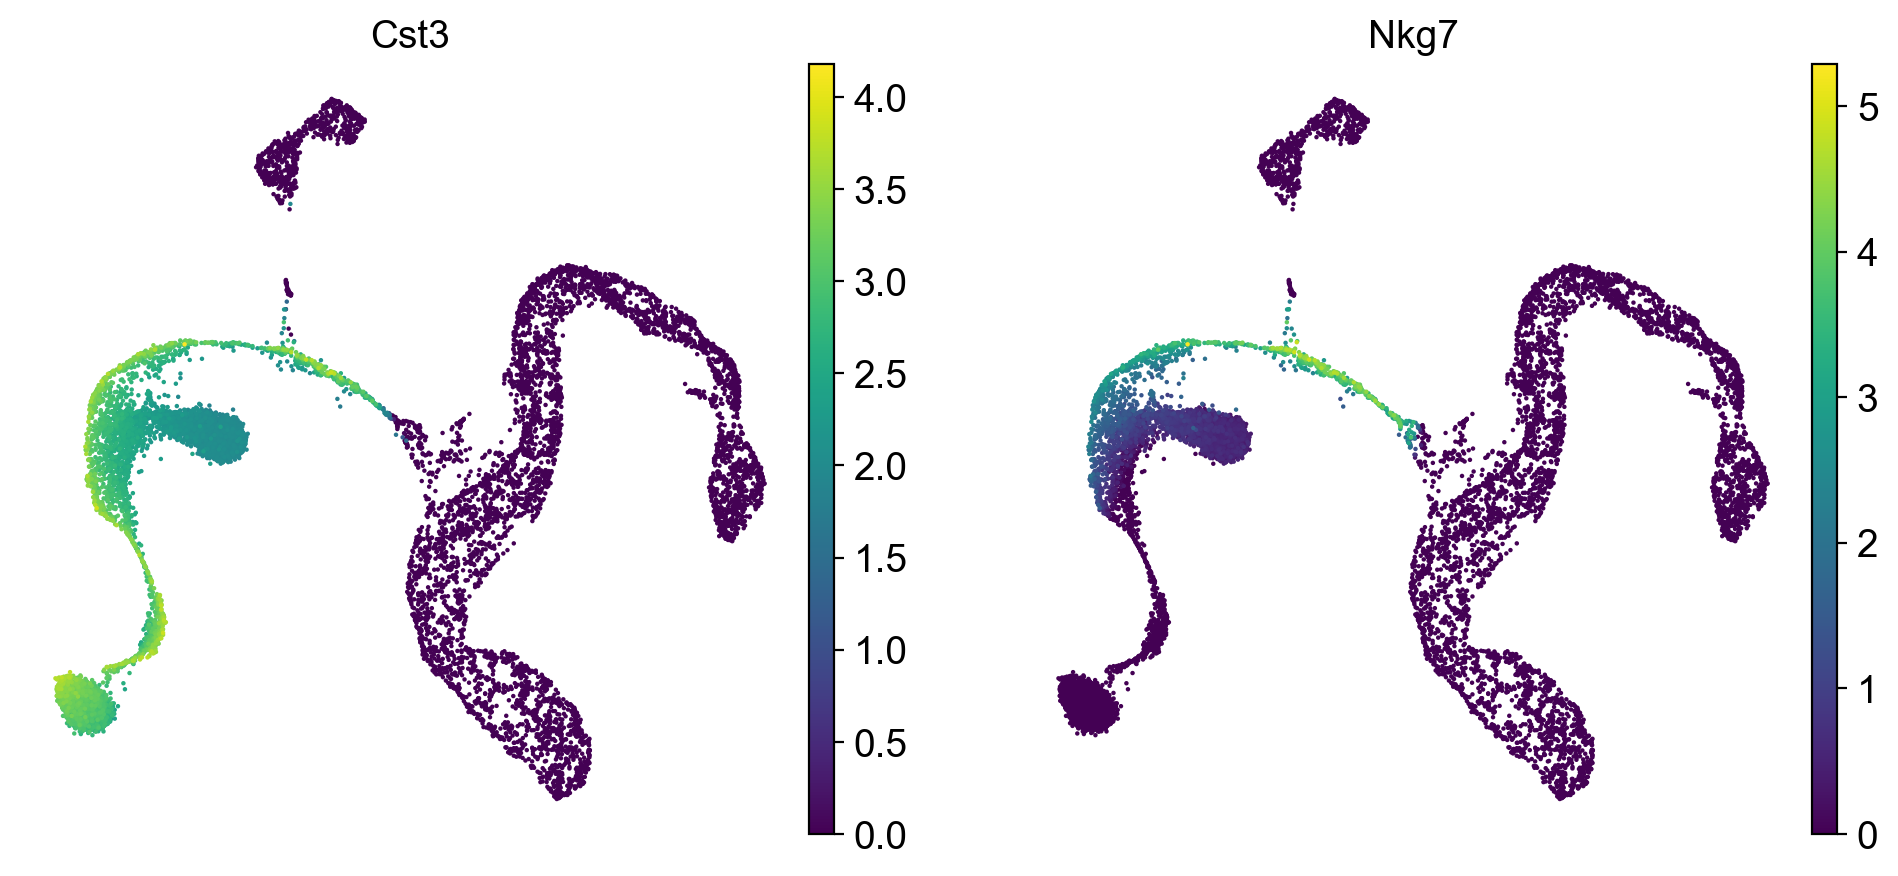

In [18]:
sc.pl.umap(adata, color=['age','leiden','cell_ontology_class'], use_raw=False)
sc.pl.umap(adata, color=['Cst3', 'Nkg7'], use_raw=False, layer='log_norm') # layer='log_norm' of the original data
sc.pl.umap(adata, color=['Cst3', 'Nkg7'], use_raw=False, layer='vae') # layer='vae' of the reconstructed data
sc.pl.umap(adata, color=['Cst3', 'Nkg7'], use_raw=False, layer='log_vae') # log-tran of the reconstructed data

# Apply Random Forest Classification

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns

In [22]:
factors = pd.factorize(adata.obs.cell_ontology_class)

In [23]:
reverse = dict(zip(range(len(factors[1])), factors[1]))

## On VAE latent space

In [24]:
X_train, X_test, y_train, y_test = train_test_split(adata.obsm['X_vae'], factors[0], test_size=0.2, random_state=0)

In [25]:
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', random_state=0)
rfc.fit(X_train, y_train)
vae_pred = rfc.predict(adata.obsm['X_vae'])

In [26]:
acc = np.equal(vae_pred, factors[0]).sum()/factors[0].shape[0] * 100
print(f'The accuracy when trained on the latent space of VAE is {acc:.2f}%')

The accuracy when trained on the latent space of VAE is 93.52%


In [27]:
adata.obs['ct_vae_pred'] = np.vectorize(reverse.get)(vae_pred)

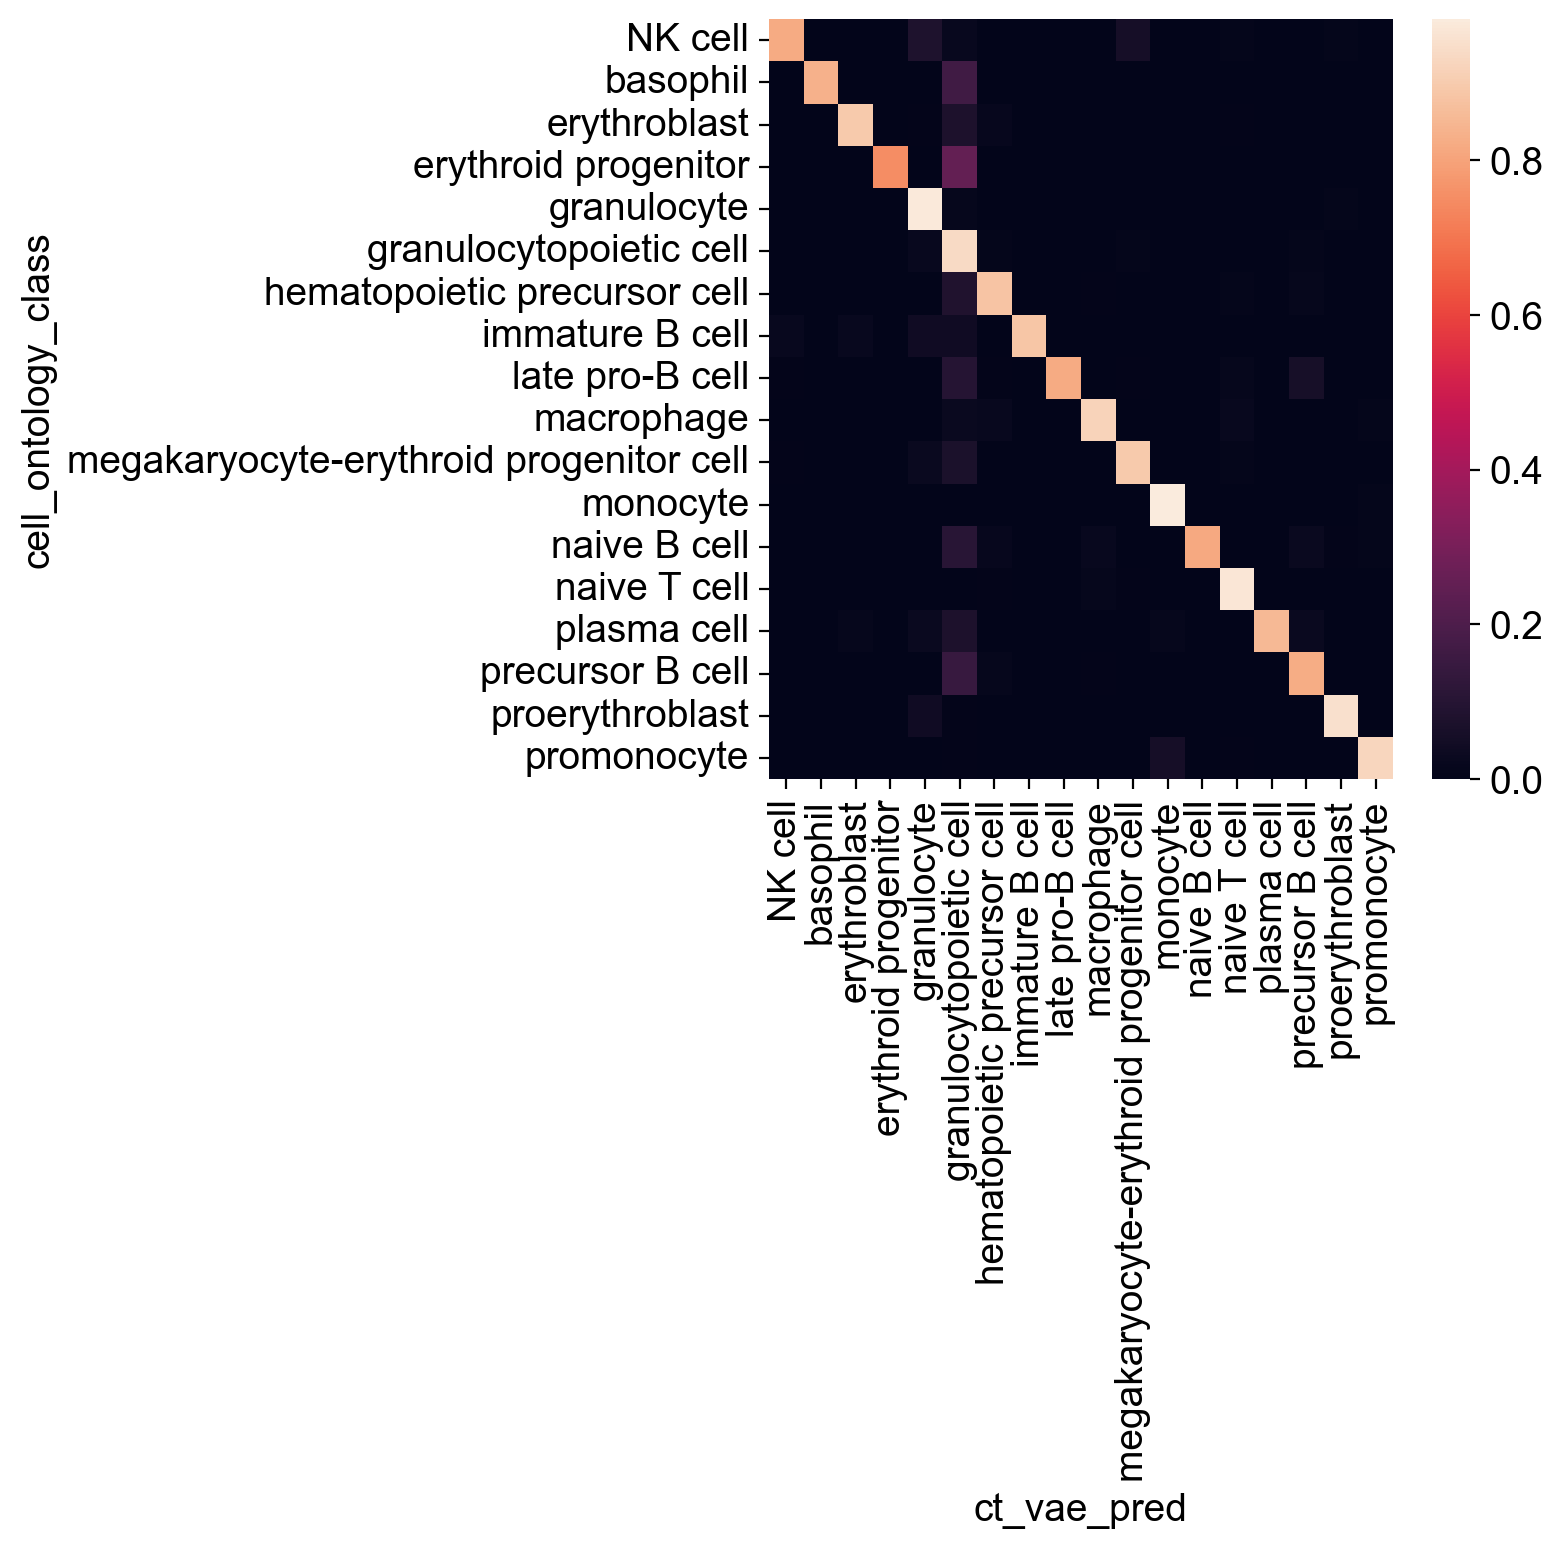

In [28]:
cmtx = sc.metrics.confusion_matrix("cell_ontology_class", "ct_vae_pred", adata.obs)
sns.heatmap(cmtx, xticklabels=True).grid(False)

## On VAE denoised expression

In [29]:
X_train, X_test, y_train, y_test = train_test_split(sc.pp.scale(adata.layers['vae'].A), factors[0], test_size=0.2, random_state=0)

In [30]:
rfc = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
rfc.fit(X_train, y_train) # scale the reconstructed data

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [31]:
recon_pred = rfc.predict(sc.pp.scale(adata.layers['vae'].A))

In [32]:
acc = np.equal(recon_pred, factors[0]).sum()/factors[0].shape[0] * 100
print(f'The accuracy when trained on the reconstructed data is {acc:.2f}%')

The accuracy when trained on the reconstructed data is 90.44%


In [33]:
adata.obs['ct_recon_pred'] = np.vectorize(reverse.get)(recon_pred)

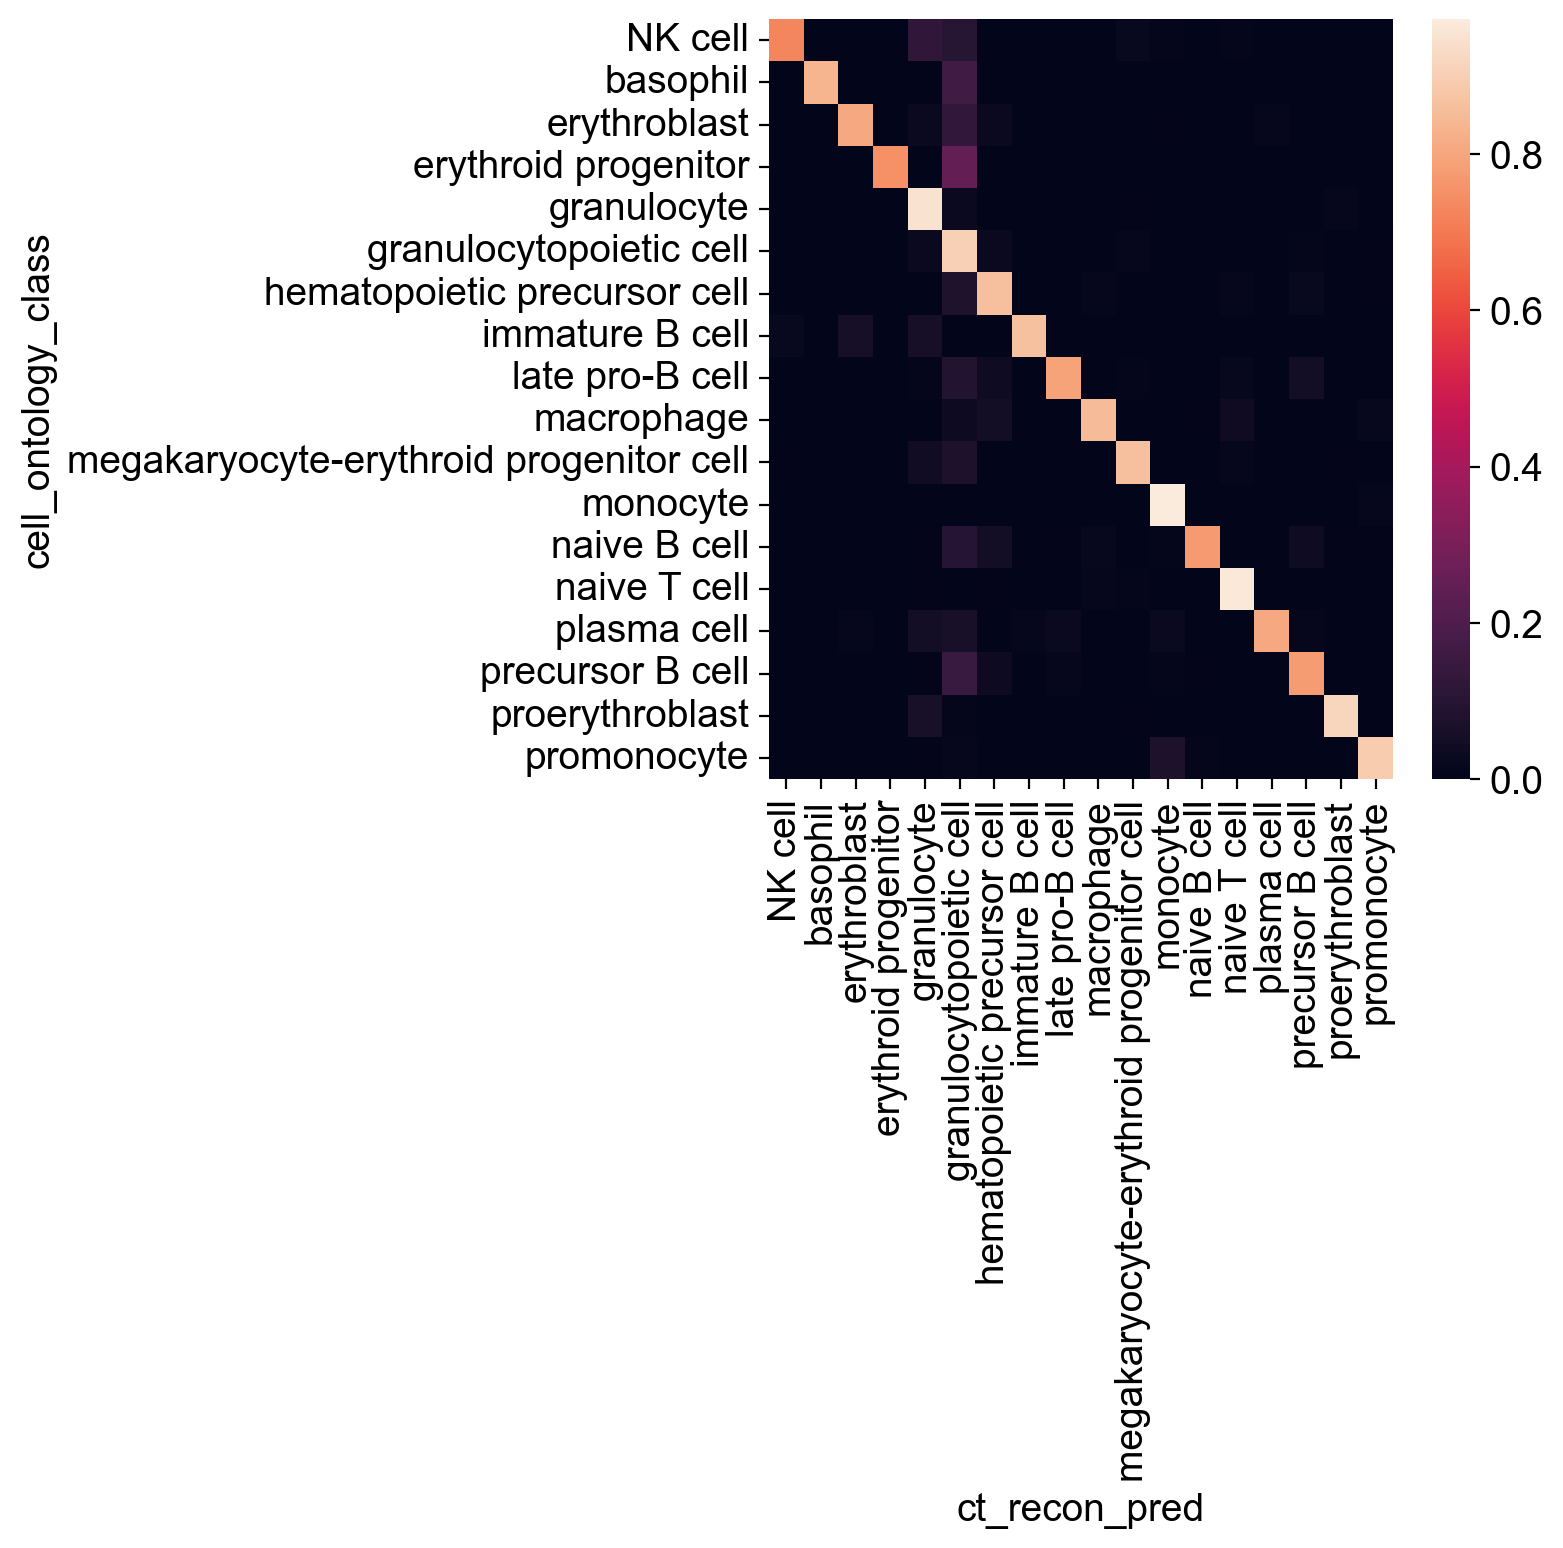

In [34]:
cmtx = sc.metrics.confusion_matrix("cell_ontology_class", "ct_recon_pred", adata.obs)
sns.heatmap(cmtx, xticklabels=True).grid(False)

## On original count data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(sc.pp.scale(adata.layers['log_norm'].A), factors[0], test_size=0.2, random_state=0)

In [36]:
rfc = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
rfc.fit(X_train, y_train) # scale the reconstructed data

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [37]:
orig_pred = rfc.predict(sc.pp.scale(adata.layers['log_norm'].A))

In [38]:
acc = np.equal(orig_pred, factors[0]).sum()/factors[0].shape[0] * 100
print(f'The accuracy when trained on the orginal data is {acc:.2f}%')

The accuracy when trained on the orginal data is 98.10%


In [39]:
adata.obs['ct_cnt_pred'] = np.vectorize(reverse.get)(orig_pred)

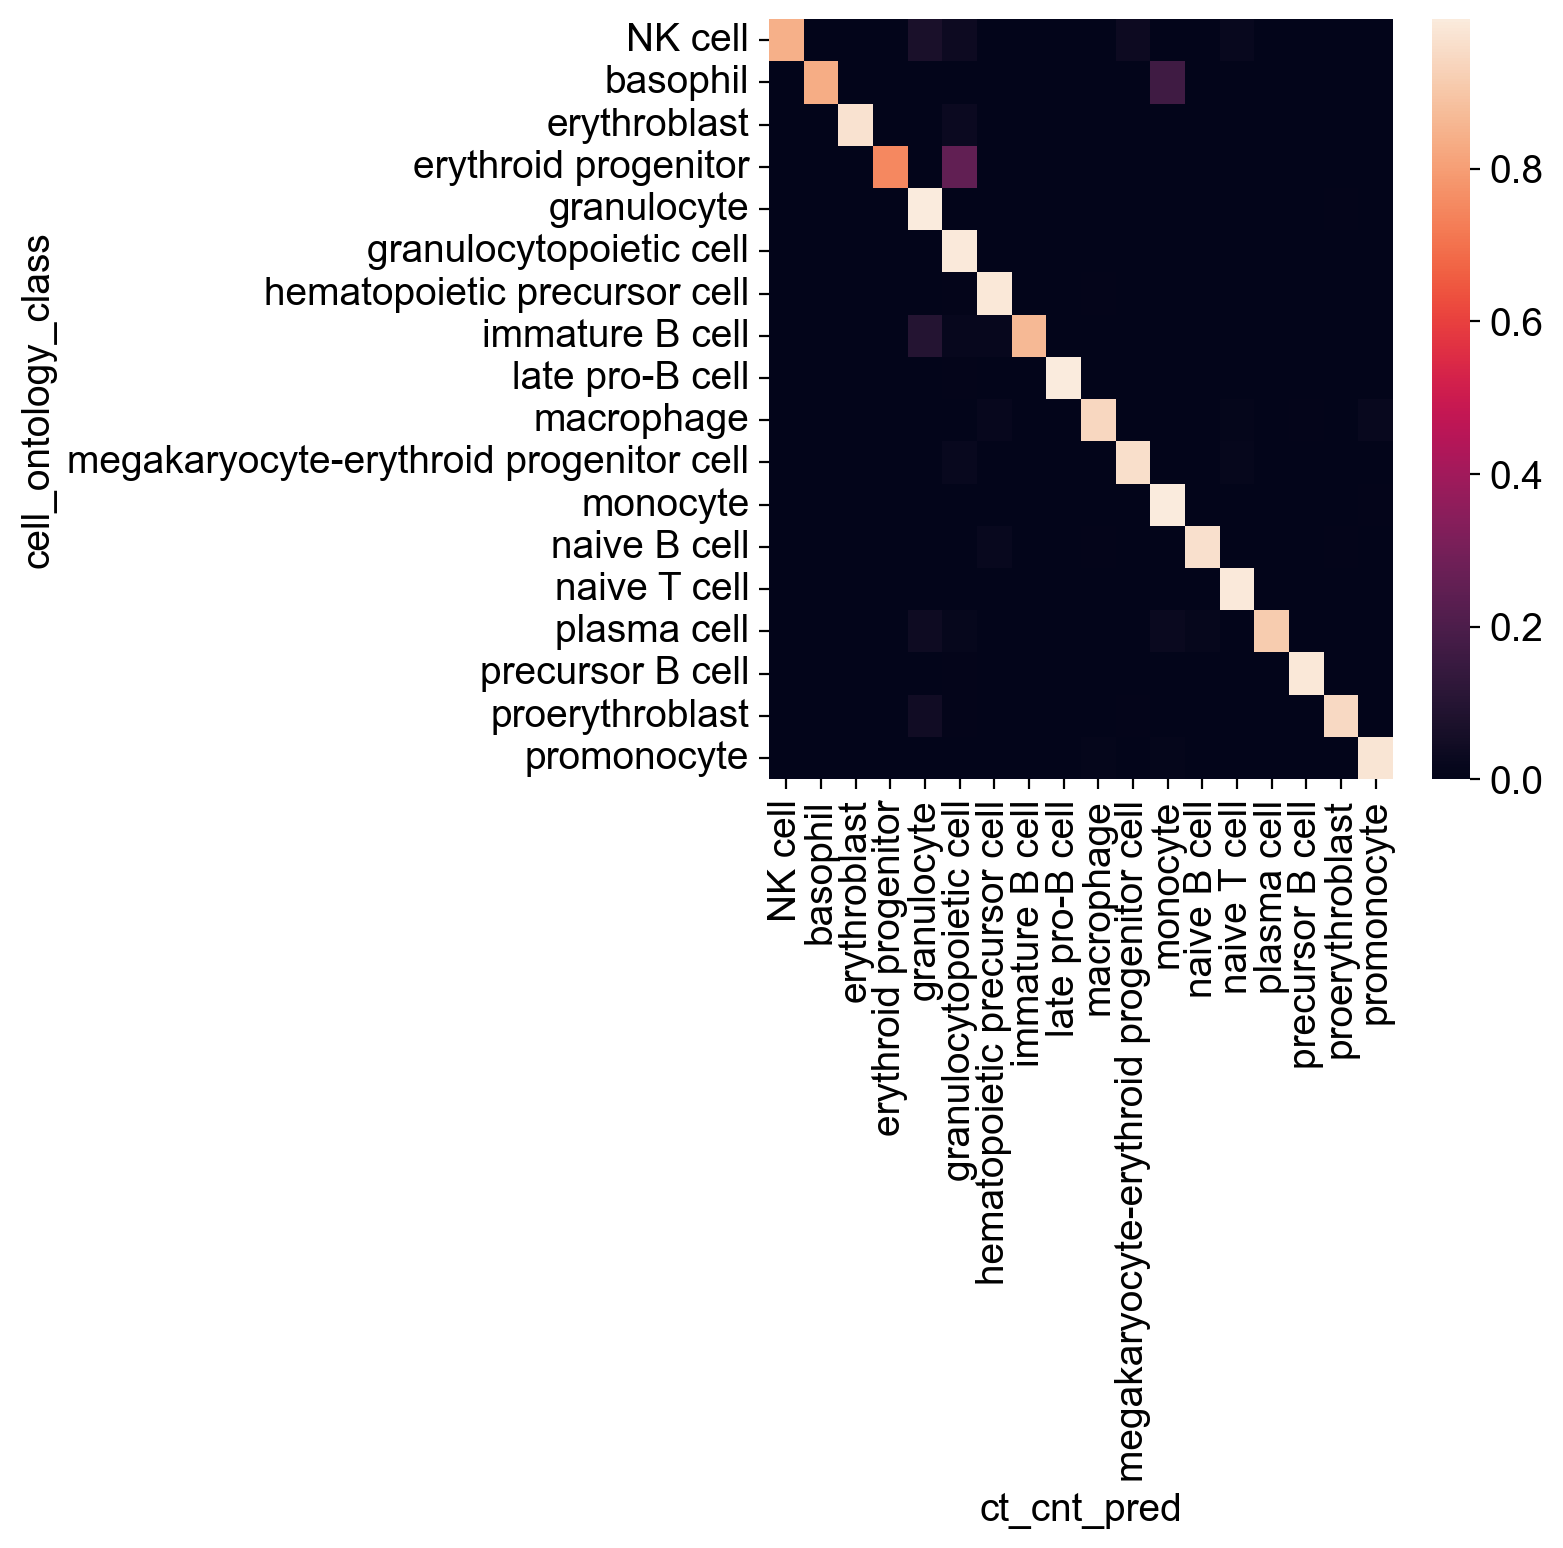

In [40]:
cmtx = sc.metrics.confusion_matrix("cell_ontology_class", "ct_cnt_pred", adata.obs)
sns.heatmap(cmtx, xticklabels=True).grid(False)

In [2]:
vae = scVAE.load_model('vae_model')

Model loaded from vae_model/model.pk
